This notebook generates the processed data for all of the chapter-specific notebooks from Poldrack, Mumford, and Nichols' _Handbook of fMRI Data Analysis (2nd Edition)_

In [1]:
import os, errno, sys,shutil

from fmrihandbook.utils.config import Config

config=Config()

%matplotlib inline

from nipype.interfaces import fsl, nipy, ants
import nibabel
from wand.image import Image as WImage
import numpy
import nilearn.plotting
import matplotlib.pyplot as plt
from nipype.caching import Memory
from nilearn.input_data import NiftiMasker
import fmrihandbook.utils
from fmrihandbook.utils.compute_fd_dvars import compute_fd,compute_dvars
import pickle

rerun_analyses=False  # set to true to force rerun of everything

# use nipype's caching mechanism to save the results of the processing
mem = Memory(base_dir='.')


/Users/poldrack/anaconda/lib/python2.7/site-packages/nipy/labs/glm/glm.py:9: FutureWarning: Module nipy.labs.utils.routines deprecated, will be removed
  from ..utils import mahalanobis
/Users/poldrack/anaconda/lib/python2.7/site-packages/nipype/interfaces/nipy/model.py:18: FutureWarning: Module nipy.labs.glm deprecated, will be removed. Please use nipy.modalities.fmri.glm instead.
  import nipy.labs.glm.glm as GLM


('using base dir:', '/Users/poldrack/data/fmri-handbook-2e-data')
no data dictionary found, checking data


## Structural preprocessing

### Bias field correction

In [2]:
try:
    assert os.path.exists(config.data['T1_bc'])
    assert os.path.exists(config.data['T1_biasfield'])
    assert not rerun_analyses
    
except:
    bias_field_correction = mem.cache(ants.N4BiasFieldCorrection)
    bias_field_correction_results = bias_field_correction(input_image = config.data['T1'], 
                                                        dimension = 3,
                                                        save_bias = True)
    print bias_field_correction_results.outputs
    outputdir=os.path.dirname(config.data['T1'])
    config.data['T1_bc']=os.path.join(outputdir,os.path.basename(bias_field_correction_results.outputs.output_image))
    config.data['T1_biasfield']=os.path.join(outputdir,
                                      os.path.basename(bias_field_correction_results.outputs.bias_image))

    shutil.copy(bias_field_correction_results.outputs.bias_image,config.data['T1_biasfield'])
    shutil.copy(bias_field_correction_results.outputs.output_image,config.data['T1_bc'])



INFO:workflow:Executing node df564d4ec67081455bc8d6a9bb28e812 in dir: /Users/poldrack/code/fmri-handbook-2e-code/notebooks/DataPreparation/nipype_mem/nipype-interfaces-ants-segmentation-N4BiasFieldCorrection/df564d4ec67081455bc8d6a9bb28e812
INFO:workflow:Collecting precomputed outputs



bias_image = /Users/poldrack/code/fmri-handbook-2e-code/notebooks/DataPreparation/nipype_mem/nipype-interfaces-ants-segmentation-N4BiasFieldCorrection/df564d4ec67081455bc8d6a9bb28e812/sub-01_ses-018_run-001_T1w_bias.nii.gz
output_image = /Users/poldrack/code/fmri-handbook-2e-code/notebooks/DataPreparation/nipype_mem/nipype-interfaces-ants-segmentation-N4BiasFieldCorrection/df564d4ec67081455bc8d6a9bb28e812/sub-01_ses-018_run-001_T1w_corrected.nii.gz



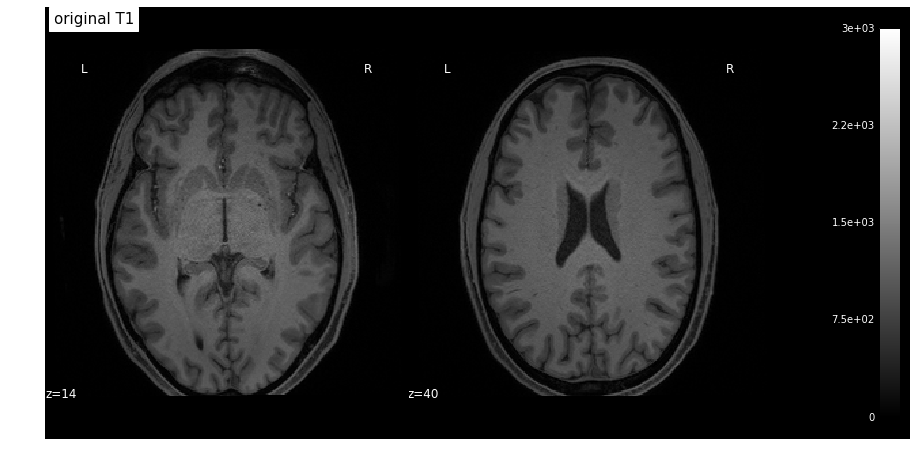

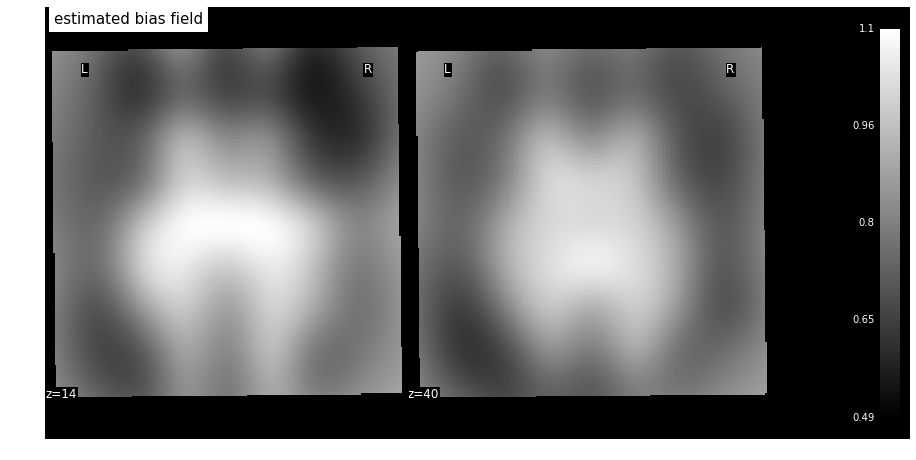

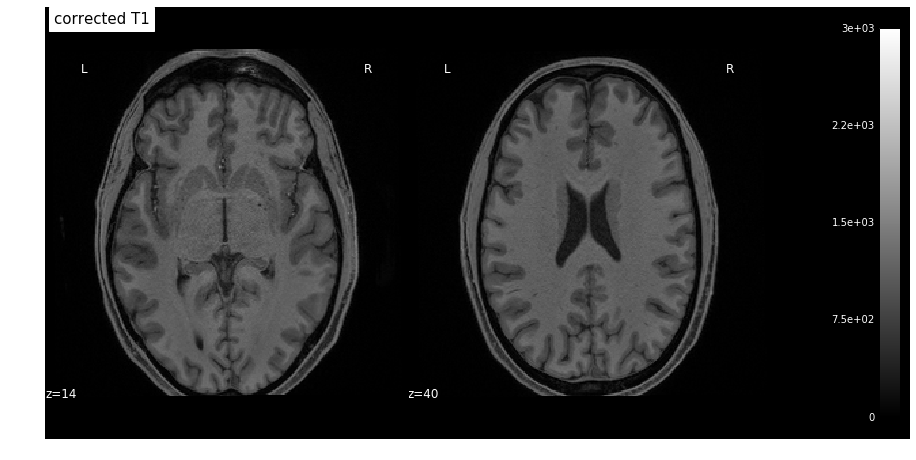

In [3]:
fig = plt.figure(figsize=(12,6))
nilearn.plotting.plot_anat(config.data['T1'], colorbar=True, vmax=3000, display_mode='z', cut_coords=(14, 40), 
                           title="original T1", figure=fig)
fig = plt.figure(figsize=(12,6))
nilearn.plotting.plot_anat(config.data['T1_biasfield'], display_mode='z', 
                          cut_coords=(14, 40), colorbar=True, 
                           title="estimated bias field", figure=fig)
fig = plt.figure(figsize=(12,6))
nilearn.plotting.plot_anat(config.data['T1_bc'], colorbar=True, 
                           vmax=3000, display_mode='z', cut_coords=(14, 40), 
                           title="corrected T1", figure=fig)

### Brain extraction using BET###

INFO:workflow:Executing node 83848520b03102e91df1a85b40f937b0 in dir: /Users/poldrack/code/fmri-handbook-2e-code/notebooks/DataPreparation/nipype_mem/nipype-interfaces-fsl-preprocess-BET/83848520b03102e91df1a85b40f937b0
INFO:workflow:Running: bet /Users/poldrack/data/fmri-handbook-2e-data/ds031/sub-01/ses-018/anat/sub-01_ses-018_run-001_T1w_corrected.nii.gz /Users/poldrack/code/fmri-handbook-2e-code/notebooks/DataPreparation/nipype_mem/nipype-interfaces-fsl-preprocess-BET/83848520b03102e91df1a85b40f937b0/sub-01_ses-018_run-001_T1w_corrected_brain.nii.gz -f 0.30 -m -B



inskull_mask_file = <undefined>
inskull_mesh_file = <undefined>
mask_file = /Users/poldrack/code/fmri-handbook-2e-code/notebooks/DataPreparation/nipype_mem/nipype-interfaces-fsl-preprocess-BET/83848520b03102e91df1a85b40f937b0/sub-01_ses-018_run-001_T1w_corrected_brain_mask.nii.gz
meshfile = <undefined>
out_file = /Users/poldrack/code/fmri-handbook-2e-code/notebooks/DataPreparation/nipype_mem/nipype-interfaces-fsl-preprocess-BET/83848520b03102e91df1a85b40f937b0/sub-01_ses-018_run-001_T1w_corrected_brain.nii.gz
outline_file = <undefined>
outskin_mask_file = <undefined>
outskin_mesh_file = <undefined>
outskull_mask_file = <undefined>
outskull_mesh_file = <undefined>
skull_mask_file = <undefined>



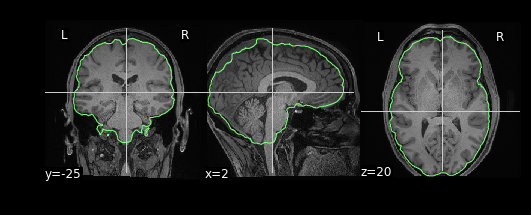

In [4]:
try:
    assert os.path.exists(config.data['T1_brain'])
    assert os.path.exists(config.data['T1_brainmask'])
    assert not rerun_analyses

except:
    bet_t1 = mem.cache(fsl.BET)
    bet_results = bet_t1(in_file=config.data['T1_bc'],
                      mask=True,
                      frac=0.3,
                     reduce_bias=True) # use reduce_bias option for neck cleanup

    mask_display=nilearn.plotting.plot_epi(config.data['T1'],cmap='gray')
    mask_display.add_contours(bet_results.outputs.mask_file, levels=[.5]) 
    print bet_results.outputs

    outputdir=os.path.dirname(config.data['T1'])
    config.data['T1_brain']=os.path.join(outputdir,os.path.basename(bet_results.outputs.out_file))
    config.data['T1_brainmask']=os.path.join(outputdir,os.path.basename(bet_results.outputs.mask_file))

    shutil.copy(bet_results.outputs.mask_file,config.data['T1_brainmask'])
    shutil.copy(bet_results.outputs.out_file,config.data['T1_brain'])


### Segmentation using FAST

Do this to obtain the white matter mask, which we need for BBR registration.

In [5]:
try:
    assert os.path.exists(config.data['T1_wmseg'])
    assert not rerun_analyses
except:
    fast_T1 = mem.cache(fsl.FAST)
    fast_results = fast_T1(in_files=[config.data['T1_brain']])
    print fast_results.outputs

    outputdir=os.path.dirname(config.data['T1_brain'])

    config.data['T1_wmseg']=os.path.join(outputdir,'sub018_t1_corrected_brain_wmseg.nii.gz')

    wmpve=nibabel.load(fast_results.outputs.partial_volume_files[2])
    wm_threshold=0.25
    wmseg=wmpve.get_data()>wm_threshold
    wmsegimg=nibabel.Nifti1Image(wmseg,wmpve.get_affine(),wmpve.get_header())
    wmsegimg.to_filename(config.data['T1_wmseg'])

INFO:workflow:Executing node e3221235d3ec598c9084a84b1dad3c2b in dir: /Users/poldrack/code/fmri-handbook-2e-code/notebooks/DataPreparation/nipype_mem/nipype-interfaces-fsl-preprocess-FAST/e3221235d3ec598c9084a84b1dad3c2b
INFO:workflow:Running: fast -S 1 /Users/poldrack/code/fmri-handbook-2e-code/notebooks/DataPreparation/nipype_mem/nipype-interfaces-fsl-preprocess-FAST/e3221235d3ec598c9084a84b1dad3c2b/sub-01_ses-018_run-001_T1w_corrected_brain.nii.gz



bias_field = <undefined>
mixeltype = /Users/poldrack/code/fmri-handbook-2e-code/notebooks/DataPreparation/nipype_mem/nipype-interfaces-fsl-preprocess-FAST/e3221235d3ec598c9084a84b1dad3c2b/sub-01_ses-018_run-001_T1w_corrected_brain_mixeltype.nii.gz
partial_volume_files = ['/Users/poldrack/code/fmri-handbook-2e-code/notebooks/DataPreparation/nipype_mem/nipype-interfaces-fsl-preprocess-FAST/e3221235d3ec598c9084a84b1dad3c2b/sub-01_ses-018_run-001_T1w_corrected_brain_pve_0.nii.gz', '/Users/poldrack/code/fmri-handbook-2e-code/notebooks/DataPreparation/nipype_mem/nipype-interfaces-fsl-preprocess-FAST/e3221235d3ec598c9084a84b1dad3c2b/sub-01_ses-018_run-001_T1w_corrected_brain_pve_1.nii.gz', '/Users/poldrack/code/fmri-handbook-2e-code/notebooks/DataPreparation/nipype_mem/nipype-interfaces-fsl-preprocess-FAST/e3221235d3ec598c9084a84b1dad3c2b/sub-01_ses-018_run-001_T1w_corrected_brain_pve_2.nii.gz']
partial_volume_map = /Users/poldrack/code/fmri-handbook-2e-code/notebooks/DataPreparation/nipype_

### Spatial normalization using ANTs

In [13]:
try:
    assert os.path.exists(config.data['T1_mni_warp'])
    assert os.path.exists(config.data['T1_mni'])
    assert  not rerun_analyses
except:
    ants_reg = mem.cache(ants.Registration)
    ants_results = ants_reg(fixed_image = os.path.join(os.getenv('FSLDIR'),'data/standard/MNI152_T1_2mm_brain.nii.gz'),
                    moving_image = config.data['T1_brain'],
                    transforms = ['Translation', 'Rigid', 'Affine', 'SyN'],
                    transform_parameters = [(0.1,), (0.1,), (0.1,), (0.2, 3.0, 0.0)],
                    #number_of_iterations = ([[10000, 111110, 11110]]*3 +
                    #                [[100, 50, 30]]),
                    number_of_iterations = ([[10, 10, 10]]*3 +
                                    [[1, 5, 3]]),
                    dimension = 3,
                    write_composite_transform = True,
                    metric = ['Mattes'] * 3 + [['Mattes', 'CC']],
                    metric_weight = [1] * 3 + [[0.5, 0.5]],
                    radius_or_number_of_bins = [32] * 3 + [[32, 4]],
                    sampling_strategy = ['Regular'] * 3 + [[None, None]],
                    sampling_percentage = [0.3] * 3 + [[None, None]],
                    convergence_threshold = [1.e-8] * 3 + [-0.01],
                    convergence_window_size = [20] * 3 + [5],
                    smoothing_sigmas = [[4, 2, 1]] * 3 + [[1, 0.5, 0]],
                    sigma_units = ['vox'] * 4,
                    shrink_factors = [[6, 4, 2]] + [[3, 2, 1]]*2 + [[4, 2, 1]],
                    use_estimate_learning_rate_once = [True] * 4,
                    use_histogram_matching = [False] * 3 + [True],
                    initial_moving_transform_com = True,
                    invert_initial_moving_transform = True,
                    output_warped_image = True)

    outputdir=os.path.dirname(config.data['T1_brain'])
    config.data['T1_mni_warp']=os.path.join(outputdir, "t1_to_mni_warp.h5")
    config.data['T1_mni']=os.path.join(outputdir,'t1_to_mni_warp.nii.gz')
    shutil.copy(ants_results.outputs.composite_transform, config.data['T1_mni_warp'])
    shutil.copy(ants_results.outputs.warped_image,config.data['T1_mni'])
    ants_results.outputs

Exception occurred in traits notification handler for object: 
args = <undefined>
collapse_output_transforms = False
convergence_threshold = [1e-06]
convergence_window_size = [20, 20, 20, 5]
dimension = 3
environ = {'NSLOTS': '1'}
fixed_image = <undefined>
fixed_image_mask = <undefined>
float = <undefined>
ignore_exception = False
initial_moving_transform = <undefined>
initial_moving_transform_com = True
initialize_transforms_per_stage = False
interpolation = Linear
interpolation_parameters = <undefined>
invert_initial_moving_transform = <undefined>
metric = ['Mattes', 'Mattes', 'Mattes', ['Mattes', 'CC']]
metric_item_trait = <undefined>
metric_stage_trait = <undefined>
metric_weight = [1.0, 1.0, 1.0, [0.5, 0.5]]
metric_weight_item_trait = <undefined>
metric_weight_stage_trait = <undefined>
moving_image = ['/Users/poldrack/data/fmri-handbook-2e-data/ds031/sub-01/ses-018/anat/sub-01_ses-018_run-001_T1w_corrected_brain.nii.gz']
moving_image_mask = <undefined>
num_threads = 1
number_of_it

IOError: Input "invert_initial_moving_transform" is mutually exclusive with input "initial_moving_transform_com", which is already set

### Register T2 to T1
    

In [ ]:
try:
    assert os.path.exists(config.data['T2_reg2T1'])
    assert os.path.exists(config.data['T2_reg2T1_mat'])
    assert not rerun_analyses
except:
    outputdir=os.path.dirname(config.data['T2'])
    config.data['T2_reg2T1']=os.path.join(outputdir,'t2_reg2t1.nii.gz')
    config.data['T2_reg2T1_mat']=os.path.join(outputdir,'t2_reg2t1.mat')
    flirt_T2_T1=mem.cache(fsl.FLIRT)
    flirt_results=flirt_T2_T1(in_file=config.data['T2'],reference=config.data['T1_bc'],
                        out_file=config.data['T2_reg2T1'],
                        cost='normmi',interp='spline')
    shutil.copy(flirt_results.outputs.out_matrix_file,config.data['T2_reg2T1_mat'])
    flirt_results.outputs

## Functional preprocessing

### Motion correction using MCFLIRT

This will take a few minutes.

In [ ]:
try:
    assert os.path.exists(config.data['meanfunc'])
    assert os.path.exists(config.data['motionpar'])
    assert os.path.exists(config.data['func_mcf'])
    assert not rerun_analyses
except:
    mcflirt = mem.cache(fsl.MCFLIRT)
    mcflirt_results = mcflirt(in_file=config.data['func'],
                              save_plots=True,
                              mean_vol=True)
    print mcflirt_results.outputs

    outputdir=os.path.dirname(config.data['func'])
    config.data['meanfunc']=os.path.join(outputdir,os.path.basename(mcflirt_results.outputs.mean_img))
    config.data['motionpar']=os.path.join(outputdir,os.path.basename(mcflirt_results.outputs.par_file))
    config.data['func_mcf']=os.path.join(outputdir,os.path.basename(mcflirt_results.outputs.out_file))

    shutil.copy(mcflirt_results.outputs.mean_img, config.data['meanfunc'])
    shutil.copy(mcflirt_results.outputs.par_file, config.data['motionpar'])
    shutil.copy(mcflirt_results.outputs.out_file, config.data['func_mcf'])


Make links for the mean functional image and the motion parameters.

## Brain extraction

Use FSL's BET to obtain the brain mask for the functional data

In [ ]:
try:
    assert os.path.exists(config.data['meanfunc_brain_mask'])
    assert os.path.exists(config.data['meanfunc_brain'])
    assert not rerun_analyses
except:
    bet_func = mem.cache(fsl.BET)
    bet_results = bet_func(functional=True,
                  in_file=config.data['meanfunc'],
                  mask=True)
    outputdir=os.path.dirname(config.data['meanfunc'])

    config.data['meanfunc_brain_mask']=os.path.join(outputdir,
                            os.path.basename(bet_results.outputs.mask_file))
    config.data['meanfunc_brain']=os.path.join(outputdir,
                            os.path.basename(bet_results.outputs.out_file))

    shutil.copy(bet_results.outputs.mask_file,config.data['meanfunc_brain_mask'] )
    shutil.copy(bet_results.outputs.out_file,config.data['meanfunc_brain'] )
    bet_results.outputs

Display the mean image, and show the outline of the brain mask.

In [ ]:
mask_display=nilearn.plotting.plot_epi(config.data['meanfunc_brain'],cmap='gray')
mask_display.add_contours(config.data['meanfunc_brain_mask'], levels=[.5])

Compute and plot the global signal within the mask across timepoints

In [ ]:
niftimasker=NiftiMasker(mask_img=config.data['meanfunc_brain_mask'])
bolddata_masked=niftimasker.fit_transform(config.data['func_mcf'])
globalmean=numpy.mean(bolddata_masked,1)

### QA for fMRI data

Load motion data and compute FD/DVARS

In [ ]:
motiondata=numpy.loadtxt(config.data['motionpar'])
fd=compute_fd(motiondata)
dvars=compute_dvars(globalmean)
outputdir=os.path.dirname(config.data['motionpar'])
config.data['FD']=os.path.join(outputdir,'FD.txt')
config.data['DVARS']=os.path.join(outputdir,'DVARS.txt')
numpy.savetxt(config.data['FD'],fd)
numpy.savetxt(config.data['DVARS'],dvars)

In [ ]:
f, (ax1, ax2,ax3)=plt.subplots(3, sharex=True)
ax1.plot(globalmean)
ax1.set_title('Mean global signal for in-mask voxels')

ax2.plot(fd)
ax2.set_title('Framewise Displacement')

ax3.plot(dvars)
ax3.set_title('DVARS')
plt.tight_layout()

## Performing Independent Component Analysis to look for artefacts

Run independent components analysis on the data using MELODIC - this will take a few minutes.

In [ ]:
try:
    assert os.path.exists(config.data['func_ica'])
    assert os.path.exists(config.data['func_ica_report'])
    assert not rerun_analyses
except:
    assert config.data['func_mcf'].find(".nii.gz")>1  # make sure replace will work properly
    config.data['func_ica']=config.data['func_mcf'].replace(".nii.gz",'.ica')
    config.data['func_ica_report']=os.path.join(config.data['func_ica'],'report')
    if not os.path.exists(config.data['func_ica']) or not os.path.exists(config.data['func_ica_report']):
        melodic = mem.cache(fsl.MELODIC)
        melodic_results = melodic(out_all=True,
                              report=True,
                              in_files=mcflirt_results.outputs.out_file,
                              mask=bet_results.outputs.mask_file)
        melodic_results.outputs
        shutil.copytree(melodic_results.outputs.out_dir,config.data['func_ica'])


Check out the MELODIC report

Load the ICA components and examine their correlation with the motion signals. For components with a correlation > 0.4, show the component voxels.

In [ ]:
ica_comps=numpy.loadtxt(os.path.join(config.data['func_ica'],'melodic_mix'))
ica_motion_corr=numpy.zeros(ica_comps.shape[1])
for c in range(ica_comps.shape[1]):
    ica_motion_corr[c]=numpy.corrcoef(ica_comps[:,c],fd)[0,1]
    if abs(ica_motion_corr[c])>0.4:
        comp_img=nibabel.load(os.path.join(config.data['func_ica'],'stats/thresh_zstat%d.nii.gz'%int(c+1)))
        nilearn.plotting.plot_stat_map(comp_img,config.data['meanfunc'],threshold=1.5,
               title='component %d - r(FD)=%0.3f'%(c+1,ica_motion_corr[c]))
        


## Fieldmap unwarping

Take the first magnitue image and skull strip it

In [ ]:
try:
    assert os.path.exists(config.data['fieldmap-mag_brain'])
    assert os.path.exists(config.data['fieldmap-mag_brain_mask'])
    assert not rerun_analyses
except:
    bet_fmap = mem.cache(fsl.BET)
    mag_bet_results = bet_fmap(functional=True,
                          in_file=config.data['fieldmap-mag'],
                          mask=True,
                          frac=0.65)

    outputdir=os.path.dirname(config.data['fieldmap-mag'])
    mag_bet_results.outputs
    config.data['fieldmap-mag_brain']=os.path.join(outputdir,
                            os.path.basename(mag_bet_results.outputs.out_file))
    config.data['fieldmap-mag_brain_mask']=os.path.join(outputdir,
                            os.path.basename(mag_bet_results.outputs.mask_file))
    shutil.copy(mag_bet_results.outputs.out_file, config.data['fieldmap-mag_brain'])
    shutil.copy(mag_bet_results.outputs.mask_file, config.data['fieldmap-mag_brain_mask'])

mask_display=nilearn.plotting.plot_epi(config.data['fieldmap-mag'],cmap='gray')
mask_display.add_contours(config.data['fieldmap-mag_brain_mask'], levels=[.5])


Prepare the fieldmap

In [ ]:
try:
    assert os.path.exists(config.data['fieldmap'])
    assert not rerun_analyses
except:
    prepare = mem.cache(fsl.PrepareFieldmap)
    prepare_results = prepare(in_phase = config.data['fieldmap-phasediff'],
                              in_magnitude = config.data['fieldmap-mag_brain'],
                              output_type = "NIFTI_GZ")

    assert config.data['fieldmap-phasediff'].find("phasediff")>1

    config.data['fieldmap']=os.path.join(outputdir,config.data['fieldmap-phasediff'].replace("phasediff",'fieldmap'))
    shutil.copy(prepare_results.outputs.out_fieldmap, config.data['fieldmap'])
    prepare_results.outputs

Which parts of the brain were most deformed by B0 inhomogeneities?

In [ ]:
nilearn.plotting.plot_stat_map(nilearn.image.index_img(config.data['fieldmap'],0), 
                               config.data['fieldmap-mag'], threshold=100)

Note that we don't really apply these transformations yet. We'll do it after first level modelling

In [ ]:
try:
    assert os.path.exists(config.data['meanfunc_unwarped'])
    assert not rerun_analyses
except:

    fugue = mem.cache(fsl.FUGUE)
    fugue_results = fugue(in_file = config.data['meanfunc'],
                          fmap_in_file = config.data['fieldmap'],
                          unwarp_direction = "y",
                          dwell_time = 2.6/10000.0,
                          mask_file = config.data['fieldmap-mag_brain_mask'])
    fugue_results.outputs
    outputdir=os.path.dirname(config.data['meanfunc'])
    config.data['meanfunc_unwarped']=os.path.join(outputdir,os.path.basename(fugue_results.outputs.unwarped_file))
    shutil.copy(fugue_results.outputs.unwarped_file,config.data['meanfunc_unwarped'])

## Combined corregistration and fieldmap unwarping using boundary based registration

In [ ]:
try:
    assert os.path.exists(config.data['meanfunc_bbreg_to_t1'])
    assert os.path.exists(config.data['meanfunc_bbreg_to_t1_mat'])
    assert os.path.exists(config.data['meanfunc_bbreg_to_t1_invmat'])
    assert os.path.exists(config.data['meanfunc_unwarped_bbreg_to_t1'])
    assert not rerun_analyses
except:
    epi_reg = mem.cache(fsl.EpiReg)
    epi_reg_results=epi_reg(epi=config.data['meanfunc'],
                              t1_head=config.data['T1_bc'],
                              t1_brain=config.data['T1_brain'],
                              fmap=config.data['fieldmap'],
                              fmapmag=config.data['fieldmap-mag'],
                              fmapmagbrain=config.data['fieldmap-mag_brain'],
                              echospacing=2.6/10000.0,
                              pedir='y',
                              out_base="epi2struct")
    
    outputdir=os.path.dirname(config.data['meanfunc'])
    config.data['meanfunc_bbreg_to_t1']=os.path.join(outputdir, "epi_bbreg_to_t1.nii.gz")
    config.data['meanfunc_bbreg_to_t1_mat']=os.path.join(outputdir, "epi_bbreg_to_t1.mat")
    config.data['meanfunc_bbreg_to_t1_invmat']=os.path.join(outputdir, "epi_bbreg_to_t1_inv.mat")
    
    shutil.copy(epi_reg_results.outputs.out_file, config.data['meanfunc_bbreg_to_t1'])
    shutil.copy(epi_reg_results.outputs.epi2str_mat , config.data['meanfunc_bbreg_to_t1_mat'])
    shutil.copy(epi_reg_results.outputs.epi2str_inv , config.data['meanfunc_bbreg_to_t1_invmat'])
    epi_reg_results.outputs
    config.data['meanfunc_unwarped_bbreg_to_t1']=os.path.join(outputdir,'epi_unwarped_bbreg_to_t1.nii.gz')
    
    flirt=mem.cache(fsl.FLIRT)
    config.data['meanfunc_unwarped_bbref_to_t1']=os.path.join(outputdir,'epi_unwarped_bbreg_to_t1.nii.gz')
    flirt_results=flirt(in_file=config.data['meanfunc_unwarped'],
                        out_file=config.data['meanfunc_unwarped_bbreg_to_t1'],
                        apply_xfm=True,in_matrix_file=config.data['meanfunc_bbreg_to_t1_mat'],
                        reference=config.data['meanfunc_unwarped'])


In [ ]:
try:
    assert os.path.exists(config.data['T1_wmseg_mni'])
    assert not rerun_analyses
except:
    T1_to_MNI_warp = mem.cache(ants.ApplyTransforms)
    T1wm_to_MNI_warp_results = T1_to_MNI_warp(input_image = config.data['T1_wmseg'],
                reference_image = os.path.join(os.getenv('FSLDIR'),'data/standard/MNI152_T1_2mm_brain.nii.gz'),
                interpolation = "NearestNeighbor",
                transforms = config.data['T1_mni_warp'])

    output_dir=os.path.dirname(config.data['T1_wmseg'])
    config.data['T1_wmseg_mni']=os.path.join(output_dir,os.path.basename(T1wm_to_MNI_warp_results.outputs.output_image))
    shutil.copy(T1wm_to_MNI_warp_results.outputs.output_image,config.data['T1_wmseg_mni'])

fig = nilearn.plotting.plot_anat(os.path.join(os.getenv('FSLDIR'),'data/standard/MNI152_T1_2mm_brain.nii.gz'))
fig.add_contours(config.data['T1_wmseg_mni'], levels=[.5]) 

## Spatial smoothing

Perform spatial smoothing using Gaussian kernel. Can you spot the difference between top and bottom rows?

In [ ]:
try:
    assert os.path.exists(config.data['func_mcf_smooth'])
    assert not rerun_analyses
except:
    smooth = mem.cache(fsl.utils.Smooth)
    smooth_results = smooth(fwhm=2.5,
                            in_file=config.data['func_mcf'],
                            output_type = "NIFTI")
    output_dir=os.path.dirname(config.data['func_mcf'])
    config.data['func_mcf_smooth']=os.path.join(output_dir,
                        os.path.basename(smooth_results.outputs.smoothed_file))
    shutil.copy(smooth_results.outputs.smoothed_file,config.data['func_mcf_smooth'])

nilearn.plotting.plot_epi(config.data['meanfunc'],
                              colorbar=True, vmin=410, vmax=21000)
nilearn.plotting.plot_epi(nilearn.image.mean_img(config.data['func_mcf_smooth']),
                              colorbar=True, vmin=410, vmax=21000)

## High pass filtering

High-pass filtering - this will take a few minutes

In [ ]:
try:
    assert os.path.exists(config.data['func_mcf_smooth_hpf_rescaled'])
    assert not rerun_analyses
except:

    hpfilt = mem.cache(fsl.maths.TemporalFilter)
    TR = 1.16
    hpfilt_results = hpfilt(highpass_sigma = 100/(2*TR),
                            in_file=config.data['func_mcf_smooth'],
                            output_type = "NIFTI")

    mean = mem.cache(fsl.maths.MeanImage)
    mean_results = mean(in_file = config.data['func_mcf_smooth'])

    rescale = mem.cache(fsl.maths.BinaryMaths)
    rescale_results = rescale(in_file=hpfilt_results.outputs.out_file,
                              operand_file = mean_results.outputs.out_file,
                              operation = "add",
                              output_type = "NIFTI")
    output_dir=os.path.dirname(config.data['func_mcf_smooth'])
    config.data['func_mcf_smooth_hpf_rescaled']=os.path.join(output_dir,
                                    os.path.basename(rescale_results.outputs.out_file))
    shutil.copy(rescale_results.outputs.out_file,config.data['func_mcf_smooth_hpf_rescaled'])


Save data dictionary

In [ ]:
import pickle
pickle.dump(data,open(datadict,'w'))

In [8]:
ants.Registration.help()



Wraps command **antsRegistration**

Examples
--------
>>> import copy, pprint
>>> from nipype.interfaces.ants import Registration
>>> reg = Registration()
>>> reg.inputs.fixed_image = 'fixed1.nii'
>>> reg.inputs.moving_image = 'moving1.nii'
>>> reg.inputs.output_transform_prefix = "output_"
>>> reg.inputs.initial_moving_transform = 'trans.mat'
>>> reg.inputs.invert_initial_moving_transform = True
>>> reg.inputs.transforms = ['Affine', 'SyN']
>>> reg.inputs.transform_parameters = [(2.0,), (0.25, 3.0, 0.0)]
>>> reg.inputs.number_of_iterations = [[1500, 200], [100, 50, 30]]
>>> reg.inputs.dimension = 3
>>> reg.inputs.write_composite_transform = True
>>> reg.inputs.collapse_output_transforms = False
>>> reg.inputs.initialize_transforms_per_stage = False
>>> reg.inputs.metric = ['Mattes']*2
>>> reg.inputs.metric_weight = [1]*2 # Default (value ignored currently by ANTs)
>>> reg.inputs.radius_or_number_of_bins = [32]*2
>>> reg.inputs.sampling_strategy = ['Random', None]
>>> reg.inputs.sampli